# Analiza podatkov in risanje

Zdaj ugriznimo v večji zalogaj: vremenske podatke.

Uporabili bomo datoteko s podatki v tej obliki:

In [1]:
print(open("vremenske-postaje.txt").read()[:300])

Murska Sobota,1961-01-01,-1,-4
Murska Sobota,1961-01-02,1,-1
Murska Sobota,1961-01-03,7,-4
Murska Sobota,1961-01-04,7,3
Murska Sobota,1961-01-05,4,-0
Murska Sobota,1961-01-06,2,-2
Murska Sobota,1961-01-07,5,0
Murska Sobota,1961-01-08,5,-1
Murska Sobota,1961-01-09,4,-1
Murska Sobota,1961-01-10,4,-1
M


Preberimo z `np.genfromtxt`; povemo, da so podatki ločeni z vejicami (`delimited=","`) in da gre za nize.

In [2]:
import numpy as np

In [3]:
podatki = np.genfromtxt(open("vremenske-postaje.txt"), delimiter=",", dtype=str)

podatki[:5]

array([['Murska Sobota', '1961-01-01', '-1', '-4'],
       ['Murska Sobota', '1961-01-02', '1', '-1'],
       ['Murska Sobota', '1961-01-03', '7', '-4'],
       ['Murska Sobota', '1961-01-04', '7', '3'],
       ['Murska Sobota', '1961-01-05', '4', '-0']], dtype='<U18')

Tako kot v zapisniku borze, obrnimo stolpce v vrstice in jih shranimo v ločene spremenljivke.

In [4]:
kraji, datumi, tmax, tmin = podatki.T

Če nas zanimajo le podatki za Ljubljano, sestavimo masko.

In [5]:
maska = kraji == "Ljubljana"

Da bo preprosteje, zdaj kar zavrzimo podatke za ostale kraje.

In [6]:
datumi = datumi[maska]
tmax = tmax[maska]
tmin = tmin[maska]

Ah, to je tako zoprno. Preprosteje bi bilo, če bi uporabili masko na celi tabeli in šele potem razpakirali. Ponovi vajo.

In [7]:
podatki = np.genfromtxt(open("vremenske-postaje.txt"), delimiter=",", dtype="U20")

maska = podatki[:, 0] == "Ljubljana"

_, datumi, tmax, tmin = podatki[maska].T

tmax = tmax.astype(float)
tmin = tmin.astype(float)

Kraj nas ne zanima (itak je vedno Ljubljana), zato smo ga shranili kar v `_`.
 
Zdaj pa pride zabava: želeli bi tabelo z (najvišjimi) temperaturami za vsak dan. Tabela bi imela tri indekse: leto, mesec in dan. Tako bi bila `temp[71, 0, 25]` temperatura 26. januarja 71. Očitno bo to tridimenzionalna tabela. Pripravimo jo: v začetku naj vsebuje same `np.nan`, not a number.

In [8]:
temp = np.full((124, 12, 31), np.nan)

Zdaj pa jo je potrebno napolniti s podatki. Potrebno bo razkopati stolpec z datumi.

In [9]:
datumi

array(['1900-01-01', '1900-01-02', '1900-01-03', ..., '2023-10-10',
       '2023-10-11', '2023-10-13'], dtype='<U20')

Na prvi pogled: radi bi celo tabelo (vse nize), vendar za vsakega le prve štiri znake.

In [10]:
datumi[:, :4]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Ne, ta tabela je enodimenzionalna in ne dovoli drugega indeksa. Numpyjeve funkcije za delo s tabelami nizov so v `np.char`. Pogled se ustavi na `np.char.split`, vendar nas ta ne osreči, saj vrne tabelo seznamov in z njimi si nimamo kaj pomagati.

In [11]:
np.char.split(datumi, "-")

array([list(['1900', '01', '01']), list(['1900', '01', '02']),
       list(['1900', '01', '03']), ..., list(['2023', '10', '10']),
       list(['2023', '10', '11']), list(['2023', '10', '13'])],
      dtype=object)

Reši nas `partition`. (Morda obstaja še kaj drugega, preprostejšega. Ta del `numpy`-ja ni moje močno področje.)

In [12]:
np.char.partition(datumi, "-")

array([['1900', '-', '01-01'],
       ['1900', '-', '01-02'],
       ['1900', '-', '01-03'],
       ...,
       ['2023', '-', '10-10'],
       ['2023', '-', '10-11'],
       ['2023', '-', '10-13']], dtype='<U5')

Metodo `partition` imajo tudi Pythonovi nizi in rezultat je enak: trije nizi - vse, kar je pred znakom, po katerem delimo, pa ta znak in potem vse, kar je za njim. Tu, v numpyju, pač namesto treh nizov dobimo tri stolpce nizov. Preobrnemo, razmečemo v vrstice. Slednjo delimo še enkrat.

In [13]:
leto, _, mes_dan = np.char.partition(datumi, "-").T
mes, _, dan = np.char.partition(mes_dan, "-").T

leto = leto.astype(int)
mes = mes.astype(int)
dan = dan.astype(int)

Tako smo dobili tri sezname, ki vsebujejo vsa leta, mesece in datume iz vseh vrstic datoteke. Pripadajoče temperature so v `tmax`, prav tako po vrsticah. In zdaj jih lahko prepišemo v tabelo `temp`.

In [14]:
temp[leto - 1900, mes - 1, dan - 1] = tmax

Od leta odštejemo 1900, od meseca in dneva pa po 1, ker ljudje iz neznanega razloga ne štejemo let od 1900 naprej, mesecev in dni pa ne od `0`.

Pa imamo: najvišja dnevna temperatura 26. januarja 1971 je bila

In [15]:
temp[71, 0, 25]

2.0

Kr mrz.

Kakšne so bile povprečne mesečne temperature od leta 2019?

Vzamemo `temp[119:]` (ker smo od let odšteli 1900) in izračunamo `nanmean` po osi 2. Os 2 so namreč dnevi v mesecu - poprečje bi radi računali prek njih.

In [16]:
np.nanmean(temp[119:], axis=2)

/var/folders/2y/4j70c4q568l1j4lb6g1r0fk00000gn/T/ipykernel_69438/117835579.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(temp[119:], axis=2)


array([[ 4.        , 11.32142857, 15.16129032, 16.73333333, 17.70967742,
        29.4       , 28.93548387, 28.32258065, 22.3       , 18.67741935,
        11.16666667,  7.06451613],
       [ 6.74193548, 11.75862069, 12.77419355, 20.1       , 20.74193548,
        24.86666667, 27.93548387, 28.16129032, 23.43333333, 16.61290323,
         9.2       ,  4.48387097],
       [ 4.09677419, 10.67857143, 13.41935484, 14.8       , 19.32258065,
        29.23333333, 29.06451613, 27.35483871, 24.3       , 14.83870968,
         8.63333333,  3.4516129 ],
       [ 5.4516129 , 10.39285714, 13.32258065, 16.13333333, 24.29032258,
        29.86666667, 30.90322581, 29.22580645, 21.53333333, 20.51612903,
        11.23333333,  6.29032258],
       [ 6.74193548,  9.07142857, 13.90322581, 15.9       , 20.5483871 ,
        26.76666667, 28.83870968, 27.93548387, 26.94444444, 23.63636364,
                nan,         nan]])

Gornje opozorilo se nanaša na zadnja elementa: za november in december 2023 nimamo podatkov (7 GB veliko datoteko s podatki za ves svet sem pobral oktobra 2023), zato je tam `nanmean` vrnil `nan`.

Kaj pa povprečne mesečne temperature nasploh?

V tem primeru povprečimo prek let in dni, le meseci morajo ostati. Osi bosta torej 0 in 2.

In [17]:
monthly = np.nanmean(temp, axis=(0, 2))

monthly_min = np.nanmin(temp, axis=(0, 2))
monthly_max = np.nanmax(temp, axis=(0, 2))

In [18]:
monthly

array([ 2.38911129,  5.54746462, 10.78914687, 15.72681704, 20.73475936,
       24.4570011 , 26.72576326, 26.07096774, 21.48240223, 15.41874323,
        8.40751121,  3.43990188])

Znamo lepše.

In [19]:
import locale
import calendar

locale.setlocale(locale.LC_ALL, "sl_SI")

for month, t in zip(calendar.month_name[1:], monthly):
    print(f"{month.title():>10}: {t:4.1f} {'*' * int(t)}")

    Januar:  2.4 **
   Februar:  5.5 *****
     Marec: 10.8 **********
     April: 15.7 ***************
       Maj: 20.7 ********************
     Junij: 24.5 ************************
     Julij: 26.7 **************************
    Avgust: 26.1 **************************
 September: 21.5 *********************
   Oktober: 15.4 ***************
  November:  8.4 ********
  December:  3.4 ***


OK, dovolj zafrkavanja: a ne bi bil čas, da narišemo zaresen graf s temperaturami?

## Risanje grafov

Za risanje grafov seveda obstaja več knjižnic, ki delujejo v različnih okoljih. Za naše potrebe je najpreprostejša takšna, ki se dobro razume z Jupyter Notebookom. (Mimogrede moram priznati, da sam ne rišem v Notebooku, temveč drugje z drugimi knjižnicami, zato nisem poseben ekspert za `matplotlib`.)

Namestimo ga s `pip install matplotlib`. Če imamo več Pythonov in se v tem ne znajdemo in če ne vemo, kje imamo `pip` in tako naprej, ga je najpreprosteje namestiti kar v Jupytru. Tako ali tako ga bomo uporabljali znotraj njega, torej ni nič narobe, če bo morda nameščen le v okolju, ki ga uporabljamo za Jupyter.

V celico napišete

```
%pip install matplotlib
```

in jo izvedete, pa bo. Če matplota še nimate, bo potrebno potem na novo pognati Python s Kernel / Restart.

Zdaj iz modula `matplotlib` uvozimo `pyplot` pod imenom `plt` (da bo manj tipkanja).

In [20]:
import matplotlib.pyplot as plt

Pa še zadnje:

In [21]:
%matplotlib inline

To so magične besede, s katerimi povemo, naj se `matplotlib`-ove slike prikažejo v beležnici. Navadno bo nepotrebna, saj je `inline` verjetno privzeta izbira. Vsaj ena alternativa, ki bi najbrž morala delovati, je `%matplotlib qt`: grafi bodo v ločenem oknu. `inline` je bolj praktičen, poleg tega pa je, vsaj pri meni, videti tudi privzet.

Potem odpremo [spletno stran matplotliba](https://matplotlib.org/stable/plot_types/index) in si izberemo tip grafa. Za temperature bodo najbrž najbolj primerni stolpci, [https://matplotlib.org/stable/plot_types/basic/bar.html#sphx-glr-plot-types-basic-bar-py].

<BarContainer object of 12 artists>

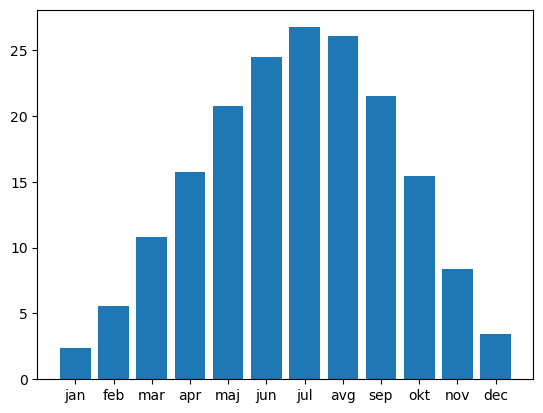

In [22]:
plt.bar(calendar.month_abbr[1:], monthly)

Ker vem, da nihče ne bo vprašal, ali se da ta graf narisati tudi vodoravno, saj je to neumno, bom to naredil kar samoiniciativno.

<BarContainer object of 12 artists>

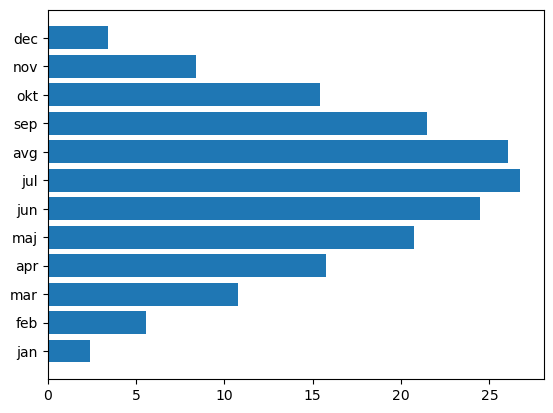

In [23]:
plt.barh(calendar.month_abbr[1:], monthly)

Da bo videti vsaj malo manj trapasto, obrnimo os `y`.

<BarContainer object of 12 artists>

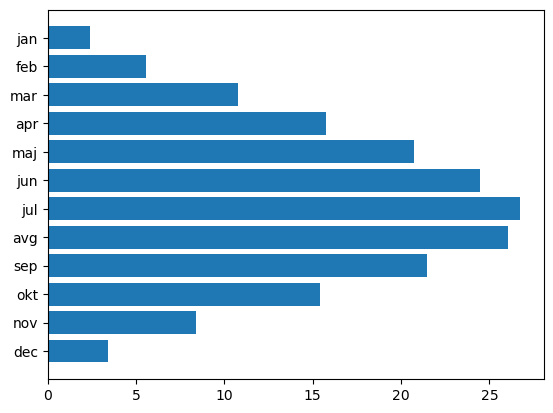

In [24]:
plt.axes().invert_yaxis()
plt.barh(calendar.month_abbr[1:], monthly)

`plt.axes()`?! Človek, ki ni vešč matplotliba, bi seveda pomislil, da gre za osi grafa. V resnici so osi tisto, kar "nariše" graf. Že prvo, kar smo naredili, je pravzaprav le okrajšava za

<BarContainer object of 12 artists>

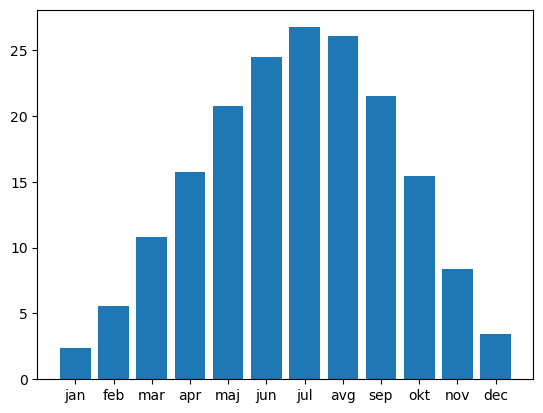

In [25]:
ax = plt.axes()
ax.bar(calendar.month_abbr[1:], monthly)

Raje ne nadaljujmo v to smer - vsaj ne, dokler nam ni treba. Raje poglejmo tole: če bi želeli namesto stolpcev narisati krivuljo, pokličemo

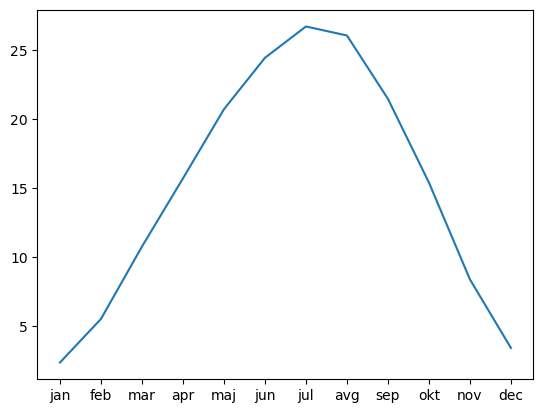

In [26]:
plt.plot(calendar.month_abbr[1:], monthly)

Nihče pa nam ne brani narisati obojega.

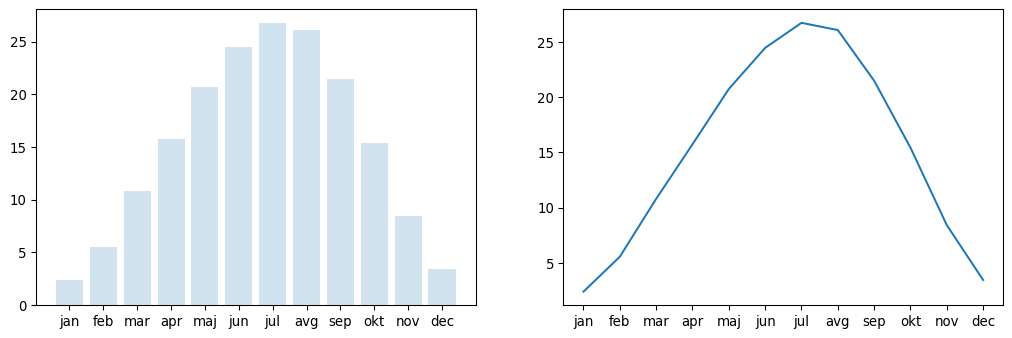

In [27]:
plt.figure(figsize=(13, 4), dpi=96)

ax = plt.subplot(1, 2, 1)
ax.bar(calendar.month_abbr[1:], monthly, alpha=0.2)

ax = plt.subplot(122)
ax.plot(calendar.month_abbr[1:], monthly)

Aja, em, ne, nisem mislil tega ... mislil sem na isti sliki. Ampak, če smo že tu - kaj je to?!

S `plt.figure(figsize=(13, 4), dpi=96)` sem povedal, da bi rad sliko velikosti 13x4 palce (ker so palci, to je, 2.54 centimetrov, najbolj standardna enota za dolžino, sploh odkar so vse enote prešle na desetiški sistem, v Evropi recimo nekje v času francoske revolucije) in da želim ločljivost 96 pik na palec. Skratka, sliko velikosti

In [28]:
13 * 96, 4 * 96

(1248, 384)

točk (pikslov, po domače). Zakaj ne podamo ločljivosti v pikslih? Čemu palci? Če že ne centimetri? Eno je, kaj se zgodi, ko sliko shranimo. Če je program, v katerega jo nosimo, kaj pameten, bo obdržal te dimenzije. Slika bo velika

In [29]:
13 * 2.54, 4 * 2.54

(33.02, 10.16)

centimetrov. Drugo, velikost pisave je podana v enotah, ki jih poznamo iz pisarniški programov, v točkah. Kot morda veste, ali pa tudi ne, je 1 pt enak 1/72 palca; 12 pt je torej 12/72 palca, torej 12 / 72 * 2.45 cm, to je, slabega pol centimetra.

In [30]:
12 / 72 * 2.54

0.42333333333333334

Ker je pisava podana v palcih, moramo podati ločljivost slike v točkah na palec, da določimo, koliko točk (recimo na zaslonu) je visoka črka.

Nadaljevali smo z

```python
ax = plt.subplot(1, 2, 1)
ax.bar(calendar.month_abbr[1:], monthly, alpha=0.2)

ax = plt.subplot(122)
ax.plot(calendar.month_abbr[1:], monthly)
```

`ax` bodo "osi", ki bodo risale grafe. S `plt.subplot(1, 2, 1)` povemo, da bi radi slike postavljene v mrežo z 1 vrstcio in 2 stolpcema, ter da bi se zdaj pogovarjali o prvi od slik v tem mreži. Zato 1, 2, 1. Potem v to sliko narišemo stolpce. `alpha=0.2` naredi stolpce malo prosojnejše, svetlejše.

Nato rečemo, da bi v to mrežo z 1 vrstico 2 stolpcema risali drugo sliko. Ker smo leni, napišemo 122 brez vejic. In potem narišemo drugo sliko.

Ampak, kot rečeno, rad bi oboje na isti sliki. To je seveda preprosteje. :)

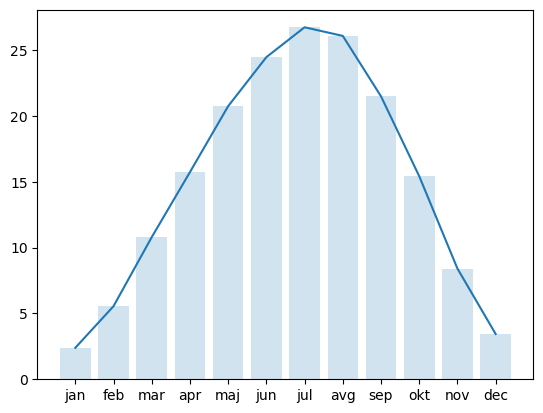

In [31]:
plt.bar(calendar.month_abbr[1:], monthly, alpha=0.2)
plt.plot(calendar.month_abbr[1:], monthly)

Zakaj bi kdo to hotel? Ne vem. Ta slika dvakrat kaže isto. Edward Tufte bi se obračal v grobu, če (a) bi jo videl in (b) ne bi bil več živ, vendar na srečo je. (In če vam pride kdaj v roke [kakšna njegova knjiga](https://www.edwardtufte.com/tufte/books_vdqi), jo le prelistajte!)

Bolj prav bi bilo narisati najvišjo in najnižjo izmerjeno mesečno temperaturo ter povprečje. Graf, ki ga potrebujemo, se imenuje `fill_between` in mu poleg podatkov za os x damo dvoje podatke za `y` - zgornje in spodnje meje. Čez to pa seveda narišemo povprečje.

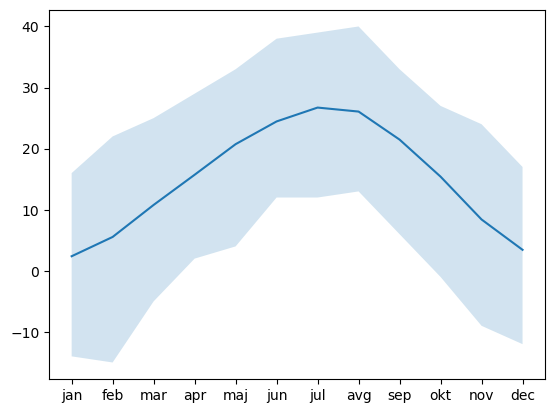

In [32]:
plt.fill_between(calendar.month_abbr[1:], monthly_min, monthly_max, alpha=0.2)
plt.plot(calendar.month_abbr[1:], monthly)

Če hočemo lepše slike, namestimo še `seaborn`: izvedemo `%pip install seaborn`, ponovno poženemo Python (Kernel / Restart), ga uvozimo in nastavimo njegovo temo.

In [33]:
import seaborn

seaborn.set_theme()

Po tem bodo slike same od sebe lepše. Predvsem pa jih bo lažje nastavljati, da bodo (še) lepše.

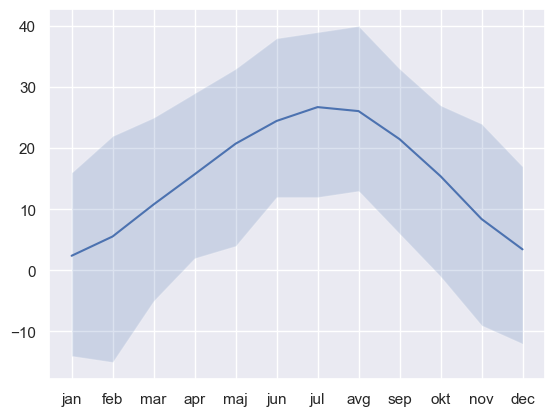

In [34]:
plt.fill_between(calendar.month_abbr[1:], monthly_min, monthly_max, alpha=0.2)
plt.plot(calendar.month_abbr[1:], monthly)

Shranimo? Pa dajmo! V png? Ali pa svg? Mogoče pfd? Prav, pdf.

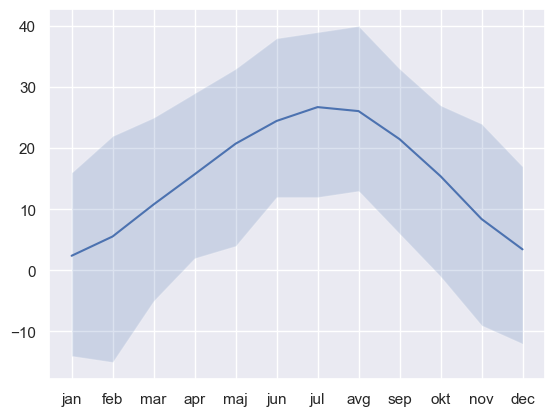

In [35]:
plt.fill_between(calendar.month_abbr[1:], monthly_min, monthly_max, alpha=0.2)
plt.plot(calendar.month_abbr[1:], monthly)
plt.savefig("mesecna-povprecja.pdf")

Delovali bodo različni formati; vsaj v .png bo šlo povsod, ostali pa so odvisni od tega, kako je zložen skupaj vaš Jupyter.

Bi v ta graf dodali povprečne mesečne temperature za zadnjih deset let?

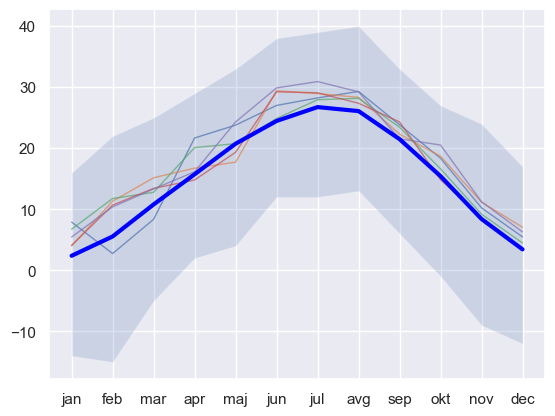

In [36]:
months = calendar.month_abbr[1:]

plt.fill_between(months, monthly_min, monthly_max, alpha=0.2)
for year in range(118, 123):
    plt.plot(months, np.nanmean(temp[year], axis=1), linewidth=1, alpha=0.7)
plt.plot(months, monthly, linewidth=3, color="blue")


Malo se igramo: črte za posamična leta smo zožali in posvetlili, poprečno pa odebelili in eksplicitno zahtevali, naj bo modra.

Ni prav prepričljivo. Morda bi črte raje zamenjali s krogci?

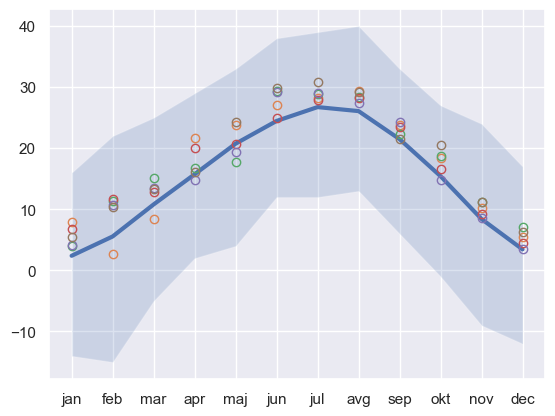

In [37]:
names = calendar.month_abbr[1:]

plt.fill_between(names, monthly_min, monthly_max, alpha=0.2)
plt.plot(names, monthly, linewidth=3)
for year in range(118, 123):
    plt.plot(names, np.nanmean(temp[year], axis=1),
             linestyle='none', marker="o", markerfacecolor="none")


Če nas zanima gledati kaj po mesecih - mogoče brki?

Pripravimo si seznam tabel: vsak element bo vseboval *vse* temperature, izmerjene v tem mesecu, v kateremkoli letu.

In [38]:
months = []
for month in range(12):
    x = temp[:, month, :].flatten()
    months.append(x[~np.isnan(x)])

S `temp[:, month, :]` povemo, da bi za radi podani mesec radi vse "vrstice" in "stolpce" - vsa leta in dneve. Tabela bo dvodimenzionalna - prvi indeks bo leto, drugi dan. S `flatten` jo potlačimo v eno samo dimenzijo. Z `x[~np.isnan(x)]` obrdržimo samo tiste elemente, ki niso `nan` - se pravi samo znane meritve.

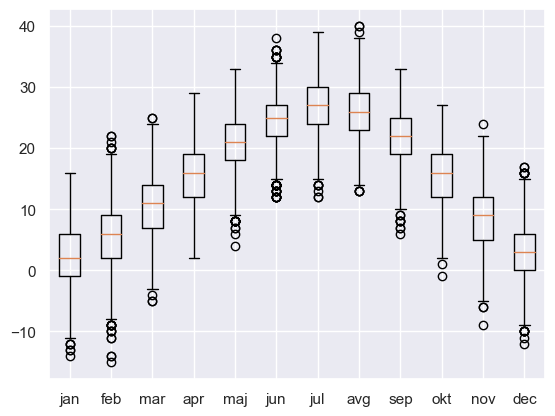

In [39]:
fig = plt.boxplot(months, labels=names)  # ker funkcija vrne kup stvari, jih shranimo v `fig`, da se ne bodo izpisale

Podobna reč, violine, pokažejo porazdelitve.

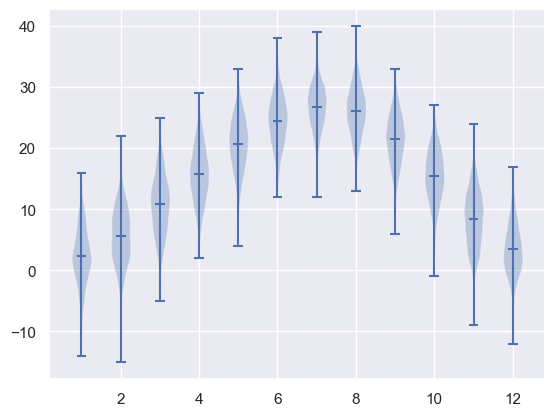

In [40]:
_ = plt.violinplot(months, showmeans=True)

Kaj pa tole? Izrišimo povprečne mesečne temperature po desetletjih.

In [41]:
monthly_by_year = np.nanmean(temp, axis=2)

/var/folders/2y/4j70c4q568l1j4lb6g1r0fk00000gn/T/ipykernel_69438/1133143241.py:1: RuntimeWarning: Mean of empty slice
  monthly_by_year = np.nanmean(temp, axis=2)


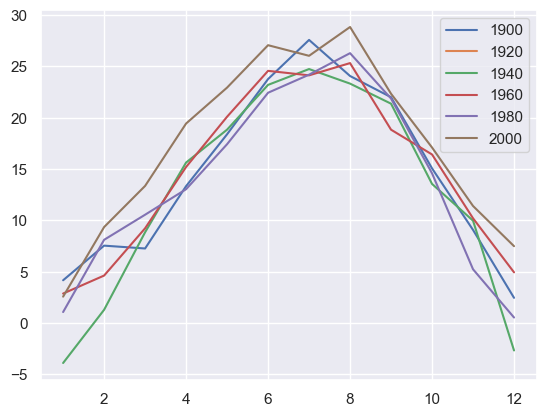

In [42]:
for decade in range(6):
    monthly = np.sum(monthly_by_year[20 * decade:20 * decade + 1], axis=0)
    plt.plot(np.arange(1, 13), monthly, label=f"{1900 + 20 * decade}")
_ = plt.legend()

Tole je pa kar zanimivo: kaže, da temperatura z leti narašča. Kdo bi si mislil?

Takole pa se sicer giba povprečna mesečna temperatura po letih.

/var/folders/2y/4j70c4q568l1j4lb6g1r0fk00000gn/T/ipykernel_69438/2795102103.py:1: RuntimeWarning: Mean of empty slice
  plt.plot(np.arange(1900, 2024), np.nanmean(temp, axis=(1, 2)))


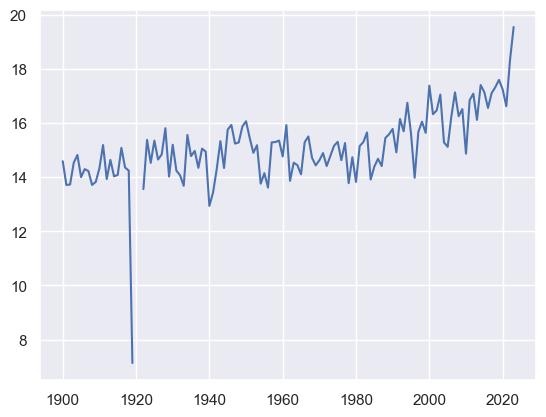

In [43]:
plt.plot(np.arange(1900, 2024), np.nanmean(temp, axis=(1, 2)))

Tule bomo nehali. Upam, da je dovolj, da vidite, da se resnih grafov ne riše z Excelom. Matplotlib je, poleg R-a, najbrž najbolj resno orodje za risanje grafov v znanosti. 

To, kar smo videli tu, ni čisto nič. Še po površini nismo popraskali. Sprehodite se po [galeriji](https://matplotlib.org/stable/gallery/), pa boste videli, da je tu najbrž vse, kar boste kdajkoli potrebovali. Ob vsaki sliki pa je tudi koda, ki jo izriše - koda, ki jo lahko skopirate in prilagodite svojim potrebam.